# Final LDA Model

In [35]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [36]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data Test

In [37]:
# Data
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/DataSample_DSP_0712.csv', index_col=1) 
df = df[df['re_tll'] != '[]'][['re_tll']] #re_bewijs
# data = [i for i in df['re_tll']]

# Data Final

In [38]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022.csv', index_col=1) 


In [39]:
df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging

In [40]:
df_be.head()

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bewijs,tll
filename,,,,,,,,
ECLI_NL_GHSHE_2021_1801.xml,9,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,2021-02-10,['[\'\\n\\n\\n\\n\\n\\nbewijsmiddelen\\n\\n\\n...,[]
ECLI_NL_GHARL_2020_820.xml,10,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,2020-01-30,"[""['\\n\\n\\n\\n\\n\\nbewijsmiddelen, feiten e...","[""[' tenlastelegging\\n\\n\\naan verdachte is ..."
ECLI_NL_RBROT_2021_2966.xml,24,ECLI:NL:RBROT:2021:2966,Strafrecht,Rotterdam,10.295806.20,2021-02-09,['[\'\\n\\nbewijswaardering\\n\\n\\n4.1.1.\\n\...,[]
ECLI_NL_RBMNE_2019_6577.xml,28,ECLI:NL:RBMNE:2019:6577,Strafrecht,Utrecht,16/018445-18,2019-01-18,"[""['\\n\\n\\nbewijsmiddelen\\n\\n\\n\\n ...","[""['\\n\\n2tenlastelegging\\n\\n\\nde tenlaste..."
ECLI_NL_GHAMS_2018_185.xml,32,ECLI:NL:GHAMS:2018:185,Strafrecht,Amsterdam,23-002003-17,2018-01-24,"[""['\\n\\n\\n\\n\\n\\nbewijsverweren\\n\\n\\n\...",[]


# Tokenize 

In [41]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df_be['bewijs']))

print(data_words[:1])

[['nbewijsmiddelen', 'nindien', 'tegen', 'dit', 'verkorte', 'arrest', 'beroep', 'in', 'cassatie', 'wordt', 'ingesteld', 'worden', 'de', 'door', 'het', 'hof', 'gebruikte', 'bewijsmiddelen', 'die', 'redengevend', 'zijn', 'voor', 'de', 'opgenomen', 'in', 'een', 'aanvulling', 'op', 'het', 'arrest', 'deze', 'aanvulling', 'wordt', 'dan', 'aan', 'dit', 'arrest', 'gehecht', 'nde', 'beslissing', 'dat', 'het', 'door', 'de', 'verdachte', 'is', 'begaan', 'berust', 'op', 'de', 'feiten', 'en', 'omstandigheden', 'als', 'vervat', 'in', 'de', 'hierboven', 'bedoelde', 'bewijsmiddelen', 'in', 'onderlinge', 'samenhang', 'beschouwd', 'nstrafbaarheid', 'van', 'het', 'nhet', 'wordt', 'als', 'volgt', 'gekwalificeerd', 'novertreding', 'van', 'een', 'voorschrift', 'gesteld', 'krachtens', 'artikel', 'eerste', 'lid', 'van', 'de', 'wet', 'milieubeheer', 'ner', 'zijn', 'geen', 'feiten', 'of', 'omstandigheden', 'aannemelijk', 'geworden', 'die', 'de', 'strafbaarheid', 'van', 'het', 'uitsluiten', 'het', 'feit', 'is', 

# Creating Bigram and Trigram Models

In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['nbewijsmiddelen_nindien', 'tegen', 'dit', 'verkorte_arrest', 'beroep', 'in', 'cassatie', 'wordt', 'ingesteld', 'worden', 'de', 'door', 'het', 'hof', 'gebruikte', 'bewijsmiddelen', 'die', 'redengevend', 'zijn', 'voor', 'de', 'opgenomen', 'in', 'een', 'aanvulling', 'op', 'het', 'arrest', 'deze', 'aanvulling', 'wordt', 'dan', 'aan', 'dit', 'arrest_gehecht', 'nde', 'beslissing', 'dat', 'het', 'door', 'de', 'verdachte', 'is', 'begaan_berust', 'op', 'de', 'feiten', 'en', 'omstandigheden', 'als', 'vervat', 'in', 'de', 'hierboven_bedoelde', 'bewijsmiddelen', 'in', 'onderlinge_samenhang_beschouwd', 'nstrafbaarheid', 'van', 'het', 'nhet', 'wordt', 'als', 'volgt_gekwalificeerd', 'novertreding', 'van', 'een', 'voorschrift', 'gesteld', 'krachtens', 'artikel', 'eerste_lid', 'van', 'de', 'wet_milieubeheer', 'ner', 'zijn', 'geen', 'feiten', 'of', 'omstandigheden_aannemelijk_geworden', 'die', 'de', 'strafbaarheid', 'van', 'het', 'uitsluiten', 'het', 'feit', 'is', 'strafbaar_nstrafbaarheid', 'van', 'd

# Remove Stopwords, Make Bigrams and Lemmatize

In [43]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [44]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('nl', disable=['parser', 'ner'])

nlp = spacy.load("nl_core_news_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['verkorte_arrest', 'beroep', 'cassatie', 'instellen', 'hof', 'gebruiken', 'bewijsmiddel', 'redengevend', 'opnemen', 'aanvulling', 'arrest', 'aanvulling', 'beslissing', 'verdenken', 'begaan_berust', 'feit', 'omstandigheid', 'vervatten', 'hierboven_bedoelde', 'bewijsmiddel', 'onderlinge_samenhang', 'beschouwen', 'nstrafbaarheid', 'novertreding', 'voorschrift', 'stellen', 'artikel', 'één', 'lid', 'feit', 'omstandigheid', 'aannemelijk_geworden', 'strafbaarheid', 'uitsluiten', 'feit', 'verdenken', 'feit', 'omstandigheid', 'aannemelijk_geworden', 'strafbaarheid', 'verdenken', 'verdenken', 'daarom', 'strafbaar', 'hiervoor', 'leggen_sanctie', 'hof', 'letten', 'aard', 'ernst', 'bewijzen', 'verklaren', 'omstandigheid', 'waaronder', 'persoon', 'verdenken', 'ander', 'onderzoek', 'ter_terechtzitting', 'voren', 'komen', 'daarnaast', 'letten', 'verhouding', 'strafbaar', 'feit', 'uitdrukking_komt', 'hierop_gestelen', 'wettelijk_strafmaximum', 'straf', 'soortgelijk', 'feit', 'opleggen', 'verdenken', 

#  Create the Dictionary and Corpus needed for Topic Modeling

In [81]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# corpus1 = [str(item) for item in corpus]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 2), (10, 1), (11, 2), (12, 1), (13, 7), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 2), (23, 1), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 8), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 14), (67, 3), (68, 2), (69, 1), (70, 2), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 3), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 5), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [46]:
# Id word
id2word[0]

'aannemelijk_geworden'

# Building the Topic Model

In [79]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [48]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"verdenken" + 0.022*"medeverdacht" + 0.017*"naam" + 0.013*"rechtbank" '
  '+ 0.009*"zeggen" + 0.009*"gaan" + 0.007*"aantreffen" + '
  '0.007*"telefoonnummer" + 0.007*"verklaren" + 0.007*"feit"'),
 (1,
  '0.043*"verdenken" + 0.029*"hof" + 0.013*"feit" + 0.012*"verklaren" + '
  '0.011*"bewijzen" + 0.010*"benadelen" + 0.009*"omstandigheid" + '
  '0.006*"oordeel" + 0.006*"artikel" + 0.006*"partij"'),
 (2,
  '0.063*"slachtoffer" + 0.039*"verdenken" + 0.016*"zien" + 0.012*"bijnaam" + '
  '0.011*"gaan" + 0.011*"medeverdacht" + 0.011*"aangeefster" + '
  '0.009*"verklaren" + 0.008*"verklaring" + 0.008*"rechtbank"'),
 (3,
  '0.042*"verdenken" + 0.019*"rechtbank" + 0.017*"zien" + 0.012*"woning" + '
  '0.012*"man" + 0.012*"aangever" + 0.011*"naam" + 0.011*"feit" + '
  '0.011*"verbalisant" + 0.009*"uur"'),
 (4,
  '0.045*"verdenken" + 0.025*"naam" + 0.013*"benadelen" + 0.012*"rechtbank" + '
  '0.010*"bedrijf" + 0.008*"geld" + 0.008*"medeverdacht" + 0.007*"bedrag" + '
  '0.007*"verklare

# Compute Model Perplexity and Coherence Score

In [49]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.3381208139627425

Coherence Score:  0.34011943471781586


# Visualize the topics-keywords

In [50]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.039469 -0.070191       1        1  24.069768
2     -0.150106  0.058571       2        1  21.780226
1      0.092607  0.152751       3        1  19.618684
4      0.131602 -0.075914       4        1  19.589774
3     -0.113573 -0.065217       5        1  14.941548, topic_info=               Term         Freq        Total Category  logprob  loglift
493     slachtoffer  7393.000000  7393.000000  Default  30.0000  30.0000
66              hof  2931.000000  2931.000000  Default  29.0000  29.0000
837            naam  5488.000000  5488.000000  Default  28.0000  28.0000
5987        bijnaam  1339.000000  1339.000000  Default  27.0000  27.0000
597            zien  3630.000000  3630.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
148          volgen   407.452356  2345.876724   Topic5  -5.2060   0.1505
501           staan   389.594938  2072.665753   Topic5  -5.2508   0.2295
368   laste_gelegen   328.581712  1108.925502   Topic5  -5.4211   0.6847
24     bewijsmiddel   332.398974  1540.215855   Topic5  -5.4096   0.3677
543      vervolgens   326.610195  1362.485758   Topic5  -5.4271   0.4727

[418 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
6622      5  0.974458         aanbellen
2518      2  0.818090       aangeefster
2518      3  0.061716       aangeefster
2518      4  0.055975       aangeefster
2518      5  0.064586       aangeefster
...     ...       ...               ...
598       4  0.037917            zitten
598       5  0.188503            zitten
2652      2  0.994480   zover_inhoudend
2653      2  0.990282  zover_inhoudenen
2653      3  0.006113  zover_inhoudenen

[813 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

# How to find the optimal number fo topics for LDA?

In [51]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [52]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=15, step=1)  # 2,40,6

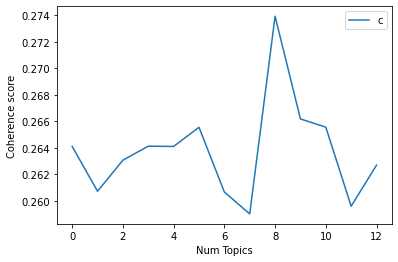

In [53]:
# Show graph

plt.plot(coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [54]:
coherence_values

[0.2641117302546816,
 0.2607352984204874,
 0.2630771269510478,
 0.2641331535382135,
 0.2641126996807665,
 0.26555682698234695,
 0.26067757145062365,
 0.25902744267065647,
 0.2739258441211337,
 0.26618771389144125,
 0.26556593983185445,
 0.25960678918407776,
 0.262704173814839]

# TF-IDF

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances

In [93]:
sample = list(df_be['bewijs'])

# Approach 1

In [94]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<669x27887 sparse matrix of type '<class 'numpy.int64'>'
	with 312574 stored elements in Compressed Sparse Row format>

In [59]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,00,000,000122,001,0011191,001191,001214,00153,002,002565,...,één,éénenveertig,éénmaal,éénmalige,ééntje,éénzijdig,òf,óf,óók,überhaupt
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
665,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
666,7,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
667,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [61]:
df

,00,000,000122,001,0011191,001191,001214,00153,002,002565,...,één,éénenveertig,éénmaal,éénmalige,ééntje,éénzijdig,òf,óf,óók,überhaupt
0,0.019691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.017951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
665,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,0.061768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
667,0.034064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df.stack().reset_index()

,level_0,level_1,0
0,0,00,0.019691
1,0,000,0.000000
2,0,000122,0.000000
3,0,001,0.000000
4,0,0011191,0.000000
...,...,...,...
18656398,668,éénzijdig,0.000000
18656399,668,òf,0.000000
18656400,668,óf,0.000000
18656401,668,óók,0.000000


In [63]:
tfidf_df = df.stack().reset_index()

In [64]:
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})

In [65]:
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

,document,term,tfidf
6494,0,de,0.435880
10740,0,het,0.313365
24532,0,van,0.303110
10873,0,hof,0.282290
4673,0,bewezenverklaarde,0.180925
...,...,...,...
18639256,668,het,0.182918
18632754,668,beroving,0.177831
18631005,668,adres2,0.165942
18631006,668,adres3,0.165942


In [66]:
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

In [67]:
# Doesn't work due to the length constraint of a document (max. 5000)

import altair as alt
import numpy as np

# Terms in this list will get a red dot in the visualization
term_list = ['slachtoffer']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand = top_tfidf_plusRand.iloc[:5000,]
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf_plusRand.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600)

alt.LayerChart(...)

# Approach 2

In [96]:
tfidf_vectorizer = TfidfVectorizer(input=sample, stop_words=stop_words)

In [97]:
tfidf_vector = tfidf_vectorizer.fit_transform(sample)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tenlastelegging'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [98]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [109]:
tfidf_df.stack().reset_index()

,level_0,level_1,0
0,0,00,0.028093
1,0,000,0.000000
2,0,000122,0.000000
3,0,001,0.000000
4,0,0011191,0.000000
...,...,...,...
18615275,00_Document Frequency,éénzijdig,1.000000
18615276,00_Document Frequency,òf,3.000000
18615277,00_Document Frequency,óf,1.000000
18615278,00_Document Frequency,óók,3.000000


In [110]:
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

In [112]:
top_tfidf[top_tfidf['term'].str.contains('hof')]

,document,term,tfidf
10836,0,hof,0.402734
38620,1,hof,0.180657
121972,4,hof,0.169649
177540,6,hof,0.145456
205324,7,hof,0.174818
...,...,...,...
17737028,638,hof,0.167929
17875948,643,hof,0.144828
18098220,651,hof,0.285996
18126004,652,hof,0.147943


In [116]:
# Doesn't work due to the length constraint of a document (max. 5000)

import altair as alt
import numpy as np

# Terms in this list will get a red dot in the visualization
term_list = ['benadeelde', 'kasboek']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand = top_tfidf_plusRand.iloc[:5000,]
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf_plusRand.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600)

alt.LayerChart(...)